In [ ]:
!pip install swig
!pip install box2d-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=2812250 sha256=611a1e445c07a9862ce0694ce7e42420071104bd14f10d8cd665ddf4eb76f1d2
  Stored in directory: /root/.cache/pip/wheels/47/01/d2/6a780da77ccb98b1d2facdd520a8d10838a03b590f6f8d50c0
Successfully built box2d-py


# Linear


-335.4995311485565


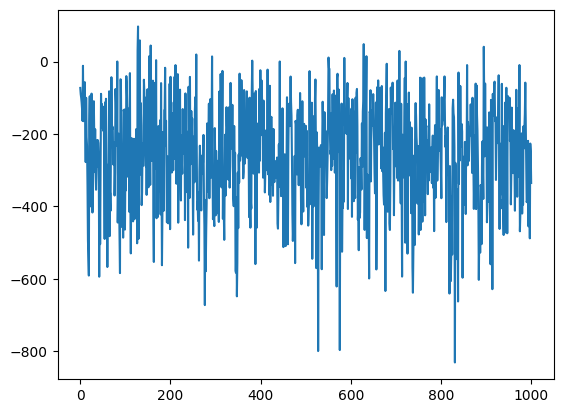

In [ ]:
import numpy as np



def linear_approximation_lander(theta, lr, env, seed=None, render=False, num_iter=50):
    train_rewards = []
    for it in range(num_iter):
        env.seed(seed)
        total_reward = 0
        steps = 0

        s = env.reset()
        s = np.append(s, 1.0)

        while True:
            predicted_reward = theta.dot(s.T)

            eps = np.random.randint(0, 100)
            if eps > 30:
                a = np.argmax(predicted_reward)
            else:
                a = np.random.randint(0, 4)

            s, r, done, info = env.step(a)

            s = np.append(s, 1.0)

            theta[a] += lr * (r - predicted_reward[a]) * s

            total_reward += r






            steps += 1
            if done: break
        train_rewards.append(total_reward)


    return theta,train_rewards


def main():
    lr = 1e-2
    theta = np.random.randn(4, 9) / 100.0

    np.random.seed(0)
    env = gym.make("LunarLander-v2")
    env.seed(0)

    theta, train_rewards = linear_approximation_lander(theta, lr, env, render=True, num_iter=1000)



    y = np.array(train_rewards)
    x = np.linspace(0, 1000, y.shape[0])
    print(y[999])

    plt.plot(x, y, label='Naive Sarsa reward')
    return train_rewards




train_rewards =main()

# SARSA

#It:  0  avg reward:  -212.02232589678593  out of  1  trials
#It:  100  avg reward:  -188.34882685949378  out of  100  trials
#It:  200  avg reward:  -193.45092356907338  out of  100  trials
#It:  300  avg reward:  -174.6188503142372  out of  100  trials
#It:  400  avg reward:  -167.42868104447112  out of  100  trials
#It:  500  avg reward:  -170.39424770254408  out of  100  trials
#It:  600  avg reward:  -158.24469276456387  out of  100  trials
#It:  700  avg reward:  -165.1466767960359  out of  100  trials
#It:  800  avg reward:  -145.76375409220356  out of  100  trials
#It:  900  avg reward:  -162.6824506348865  out of  100  trials
#It:  1000  avg reward:  -160.5646115089795  out of  100  trials
#It:  1100  avg reward:  -155.25541471789697  out of  100  trials
#It:  1200  avg reward:  -159.1705015436234  out of  100  trials
#It:  1300  avg reward:  -171.85011648780926  out of  100  trials
#It:  1400  avg reward:  -129.939605251473  out of  100  trials
#It:  1500  avg reward:  -143.8

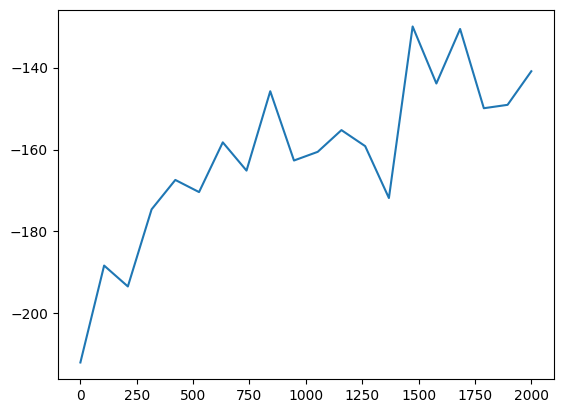

In [ ]:
import collections
import random
import numpy as np
import matplotlib.pyplot as plt



def state_extractor(s):

    state = (int((s[0] - 0.3 / 2.0) / 0.3), \
            int((s[1] - 0.3 / 2.0) / 0.3), \
            int((s[2] - 0.2 / 2.0) / 0.2), \
            int((s[3] - 0.2 / 2.0) / 0.2), \
            int((s[4] - 0.2 / 2.0) / 0.2), \
            int((s[5] - 0.2 / 2.0) / 0.2), \
            int(s[6]), \
            int(s[7]))

    return state


def lr_scheduler(it):
    return 1e-2


def sa_key(s, a):
    return str(s) + " " + str(a)


def policy_explorer(s, Q, iter):
    rand = np.random.randint(0, 100)

    threshold = 20

    if rand >= threshold:
        Qv = np.array([ Q[sa_key(s, action)] for action in [0, 1, 2, 3]])
        return np.argmax(Qv)
    else:
        return np.random.randint(0, 4)




def sarsa_lander(env, seed=None, render=False, num_iter=50, seg=50):
    env.seed(42)

    Q = collections.defaultdict(float)

    gamma = 0.95

    r_seq = []
    it_reward = []

    for it in range(num_iter):
        # initialize variables
        total_reward = 0
        steps = 0

        lr = lr_scheduler(it)

        # reset environment
        s = env.reset()

        ds = state_extractor(s)
        a = policy_explorer(ds, Q, it)
        # start Sarsa
        while True:
            # use a policy generator to guide sarsa exploration
            # step and get feedback
            sa = sa_key(ds, a)

            sp, r, done, info = env.step(a)
            # update corresponding Q
            dsp = state_extractor(sp)
            ap = policy_explorer(dsp, Q, it)

            next_sa = sa_key(dsp, ap)

            if not done:
                Q[sa] += lr*(r + gamma * Q[next_sa] - Q[sa])
            else:
                Q[sa] += lr*(r - Q[sa])


            ds = dsp
            a = ap

            total_reward += r


            # if steps % 20 == 0 or done:
            #     print("observations:", " ".join(["{:+0.2f}".format(x) for x in s]))
            #     print("step {} total_reward {:+0.2f}".format(steps, total_reward))

            steps += 1

            if done or steps > 1000:
                # if total_reward > 50:
                #     print(ds, a, total_reward)
                it_reward.append(total_reward)
                break

        if it % seg == 0:
            avg_rwd = np.mean(np.array(it_reward))
            print("#It: ", it, " avg reward: ", avg_rwd, " out of ", len(it_reward), " trials")
            it_reward = []
            r_seq.append(avg_rwd)

    return Q, r_seq


def main():
    num_iter = 2000


    np.random.seed(0)
    env = gym.make("LunarLander-v2")
    env.seed(0)
    Q, r_seq = sarsa_lander(env, render=False, num_iter=num_iter, seg=100)

    y = np.array(r_seq)
    x = np.linspace(0, num_iter, y.shape[0])

    plt.plot(x, y, label='Naive Sarsa reward')




main()

# DQN

<ipython-input-2-b2d19780775b>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_choices = np.array(memory)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 16ms/step
Episode = 23, Score = -229.02929108129828, Avg_Score = -144.7382795044443
1/1 [==============================] - 0s 17ms/step
Episode = 24, Score = 127.19318956534525, Avg_Score = -133.8610207416527
1/1 [==============================] - 0s 18ms/step
Episode = 25, Score = -207.44809133666183, Avg_Score = -136.6912926876146
1/1 [==============================] - 0s 18ms/step
Episode = 26, Score = -49.967020535895635, Avg_Score = -133.4792826079213
1/1 [==============================] - 0s 18ms/step
Episode = 27, Score = 90.81111876776882, Avg_Score = -125.4689111302181
1/1 [==============================] - 0s 18ms/step
Episode = 28, Score = -259.1172769609575, Avg_Score = -130.0774754692091
1/1 [==============================] - 0s 20ms/step
Episode = 29, Score = -36.17734411539128, Avg_Score = -126.94747109074852


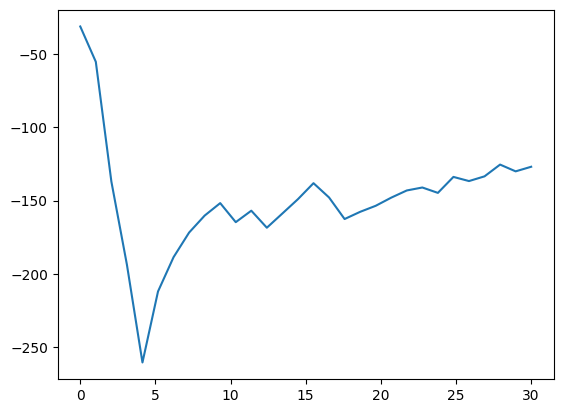

In [ ]:
import numpy as np
import keras
from keras.activations import relu, linear

import matplotlib.pyplot as plt
from collections import deque
import gym
import random
from keras.utils import to_categorical


learning_rate = 0.001
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_dim=8, activation=relu))
model.add(keras.layers.Dense(64, activation=relu))
model.add(keras.layers.Dense(4, activation=linear))
opt =keras.optimizers.Adam(learning_rate=learning_rate )
model.compile(loss="mse", optimizer=opt)

epsilon = 1
gamma = .99
batch_size = 64
memory = deque(maxlen=1000000)
min_eps = 0.01
model = model

def replay_experiences():
    if len(memory) >= batch_size:
        sample_choices = np.array(memory)
        #print(sample_choices)
        mini_batch_index = np.random.choice(len(sample_choices), batch_size,replace= False)
        #batch = random.sample(memory, batch_size)
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        for index in mini_batch_index:
            states.append(memory[index][0])
            actions.append(memory[index][1])
            next_states.append(memory[index][2])
            rewards.append(memory[index][3])
            finishes.append(memory[index][4])
        states = np.array(states)
        actions = np.array(actions)

        next_states = np.array(next_states)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        q_vals_next_state = model.predict_on_batch(next_states )
        q_vals_target = model.predict_on_batch(states)
        max_q_values_next_state = np.amax(q_vals_next_state, axis=1)
        q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)
        model.fit(states, q_vals_target, verbose=0)
        global epsilon
        if epsilon > min_eps:
            epsilon *= 0.996


def aaa():
    env = gym.make("LunarLander-v2")
    env.seed(1)
    num_episodes = 400
    np.random.seed(1)
    scores  = []
    avg_scores=[]
    num_iters= 0
    for i in range(30):
        score = 0
        num_iters+=1
        state = env.reset()
        finished = False
        for j in range(3000):
            state = np.reshape(state, (1, 8))
            if np.random.random() <= epsilon:
                action =  np.random.choice(4)
            else:
                action_values = model.predict(state)
                action = np.argmax(action_values[0])

            next_state, reward, finished, metadata  = env.step(action)

            next_state = np.reshape(next_state, (1, 8))
            memory.append((state, action, next_state, reward, finished))
            replay_experiences()
            score += reward
            state = next_state
            if finished:
                scores.append(score)

                avg_scores.append(np.mean(scores[-100:]))

                print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
                break
    return avg_scores, num_iters
avg_score_dqn, num_iters_dqn =aaa()
y = np.array(avg_score_dqn)
x = np.linspace(0, num_iters_dqn, y.shape[0])

plt.plot(x, y, label='DQN reward')

# Dueling DQN

In [ ]:
import numpy as np
import keras
from keras.activations import relu, linear
#--------------           ---------------#
import matplotlib.pyplot as plt
from collections import deque
import gym
import random
import tensorflow as tf
from keras.utils import to_categorical


learning_rate = 0.001

def DDQN_model():
    input_layer = keras.layers.Input(shape=8)
    dense1 = keras.layers.Dense(64, activation=relu)(input_layer)
    dense2 = keras.layers.Dense(64, activation=relu)(dense1)

    state_value = keras.layers.Dense(1, activation=linear)(dense2)

    action_advantage = keras.layers.Dense(4, activation=linear)(dense2)

    output_layer =  (state_value + (action_advantage - tf.math.reduce_mean(action_advantage, axis=1, keepdims=True)))


    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model


model = DDQN_model()
opt =keras.optimizers.Adam(learning_rate=learning_rate )
model.compile(loss="mse", optimizer=opt)

epsilon = 1
gamma = .99
batch_size = 64
memory =  deque(maxlen=1000000)
min_eps = 0.01

def replay_experiences():
    if len(memory) >= batch_size:
        sample_choices = np.array(memory)
        mini_batch_index = np.random.choice(len(sample_choices), batch_size,replace= False)
        #batch = random.sample(memory, batch_size)
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        for index in mini_batch_index:
            states.append(memory[index][0])
            actions.append(memory[index][1])
            next_states.append(memory[index][2])
            rewards.append(memory[index][3])
            finishes.append(memory[index][4])
        states = np.array(states)
        actions = np.array(actions)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        q_vals_next_state = model.predict_on_batch(next_states)

        q_vals_target = model.predict_on_batch(states)
        max_q_values_next_state = np.amax(q_vals_next_state, axis=1)
        q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)
        model.fit(states, q_vals_target, verbose=0)


        global epsilon
        if epsilon > min_eps:
            epsilon *= 0.996


def aaa():
    env = gym.make("LunarLander-v2" )
    env.seed(1)
    num_episodes = 400
    np.random.seed(1)
    scores  = []
    avg_scores=[]
    num_iters= 0
    for i in range(30):
        score = 0
        num_iters+=1
        state = env.reset()
        finished = False

        for j in range(3000):
            state = np.reshape(state, (1, 8))

            if np.random.random() <= epsilon:
                action =  np.random.choice(4)
            else:
              action_values = model.predict(state)
              action = np.argmax(action_values[0])


            next_state, reward, finished, metadata = env.step(action)
            next_state = np.reshape(next_state, (1, 8))
            memory.append((state, action, next_state, reward, finished))
            replay_experiences()
            score += reward
            state = next_state
            if finished:
                scores.append(score)

                avg_scores.append(np.mean(scores[-100:]))

                print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
                break
    return avg_scores, num_iters
avg_scores_dueling_dqn, num_iters_dueling_dqn =aaa()
y = np.array(avg_scores_dueling_dqn)
x = np.linspace(0, num_iters_dueling_dqn, y.shape[0])

plt.plot(x, y, label='Dueling DQN reward')

Episode = 0, Score = -142.2203711652004, Avg_Score = -142.2203711652004


<ipython-input-7-6efaa4c5c07f>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_choices = np.array(memory)


1/1 [==============================] - 0s 19ms/step
Episode = 1, Score = -117.46464634374627, Avg_Score = -129.84250875447333
1/1 [==============================] - 0s 24ms/step
Episode = 2, Score = -211.5717678070935, Avg_Score = -157.0855951053467
1/1 [==============================] - 0s 20ms/step
Episode = 3, Score = -106.68606227281292, Avg_Score = -144.48571189721326
1/1 [==============================] - 0s 22ms/step
Episode = 4, Score = -442.8057629024823, Avg_Score = -204.14972209826706
1/1 [==============================] - 0s 22ms/step
Episode = 5, Score = -170.88819535938993, Avg_Score = -198.60613430845422
1/1 [==============================] - 0s 20ms/step
Episode = 6, Score = -219.71041454418685, Avg_Score = -201.62103148498747
1/1 [==============================] - 0s 29ms/step
Episode = 7, Score = -138.59169471186962, Avg_Score = -193.7423643883477
1/1 [==============================] - 0s 19ms/step
Episode = 8, Score = -395.4418028175779, Avg_Score = -216.153413102706

KeyboardInterrupt: ignored

# Priotorized DQN

In [ ]:
import numpy as np
import keras
from keras.activations import relu, linear
import keras
import matplotlib.pyplot as plt
from collections import deque
import gym
import random
from keras.utils import to_categorical

import tensorflow as tf



learning_rate = 0.001
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_dim=8, activation=relu))
model.add(keras.layers.Dense(64, activation=relu))
model.add(keras.layers.Dense(4, activation=linear))
opt =keras.optimizers.Adam(learning_rate=learning_rate )
model.compile(loss="mse", optimizer=opt)




epsilon = 1
gamma = .99
batch_size = 64
memory = deque(maxlen=1000000)
min_eps = 0.01



def update_prior(mini_batch_index):
    states = []
    actions = []
    next_states = []
    rewards = []
    finishes = []
    for index in mini_batch_index:
          states.append(memory[index][0])
          actions.append(memory[index][1])
          next_states.append(memory[index][2])
          rewards.append(memory[index][3])
          finishes.append(memory[index][4])
    states_ = np.squeeze(states)
    next_states_ = np.squeeze(next_states)

    q_vals_next_state = model.predict_on_batch(next_states_)
    q_vals_target = model.predict_on_batch(states_)

    max_q_values_next_state = np.amax(q_vals_next_state, axis=1)

    for i in range(64):
      td_errors = np.abs((rewards[i] + gamma * (max_q_values_next_state[i]) * (1 - finishes[i])) - q_vals_target[i][actions[i]])

      memory[mini_batch_index[i]]= (states[i], actions[i], next_states[i], rewards[i], finishes[i],  td_errors)




def replay_experiences():
    if len(memory) >= batch_size:

        priorities = np.array([ (exp[5])**0.2 for exp in memory])

        priorities =priorities/ np.sum(priorities)


        mini_batch_index = np.random.choice(len(memory), batch_size, p= priorities,replace= True)

        #batch = random.sample(memory, batch_size)
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        errors = []
        for index in mini_batch_index:
            states.append(memory[index][0])
            actions.append(memory[index][1])
            next_states.append(memory[index][2])
            rewards.append(memory[index][3])
            finishes.append(memory[index][4])
            errors.append(memory[index][5])
        states = np.array(states)
        actions = np.array(actions)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)


        q_vals_next_state = model.predict_on_batch(next_states)
        q_vals_target = model.predict_on_batch(states)
        max_q_values_next_state = np.amax(q_vals_next_state, axis=1)


        we = [((1/w)* (1/len(memory))  )**0.8  for  w in  priorities[mini_batch_index]]

        max_w = np.amax(we)

        curr= list( element[actions[idx]] for idx,element in enumerate(q_vals_target))
        td = np.abs((rewards + gamma*max_q_values_next_state )- curr)
        we = [er*(w)  for er, w in zip(td, we)]


        we = [w/max_w  for  w in we]


        q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)

        callback = GradientWeightedUpdateCallback(we,model,states, q_vals_target)
        model.fit(states, q_vals_target, verbose=0,callbacks=[callback])
        #model.fit(states, q_vals_target, verbose=0)
        update_prior(mini_batch_index)
        global epsilon
        if epsilon > min_eps:
            epsilon *= 0.996



class GradientWeightedUpdateCallback(tf.keras.callbacks.Callback):
    def __init__(self, weights,model,inputs,targets):
        super(GradientWeightedUpdateCallback, self).__init__()
        self.weights = weights
        self.model = model
        self.inputs = inputs
        self.targets= targets


    def on_train_batch_end(self, batch, logs=None):
        # Get the gradients
        with tf.GradientTape() as tape:
            predictions = self.model(self.inputs)  # Replace 'inputs' with your input data

            loss_value = self.model.compiled_loss(tf.convert_to_tensor(self.targets), predictions)  # Replace 'targets' with your target labels
        gradients = tape.gradient(loss_value, self.model.trainable_weights)




        # Perform element-wise multiplication of gradients and weights
        weighted_gradients = [g*w  for g, w in zip(gradients, self.weights)]

        # Apply the weighted gradients to update the model parameters
        self.model.optimizer.apply_gradients(zip(weighted_gradients, self.model.trainable_weights))
        return


def priotirized_append(state, action, next_state, reward, finished):



    q_vals_next_state = model.predict_on_batch(next_state)

    q_vals_target = model.predict_on_batch(state)

    max_q_values_next_state = np.amax(q_vals_next_state, axis=1)[0]

    td_errors = np.abs((reward + gamma * (max_q_values_next_state) * (1 - finished)) - q_vals_target[0][action])

    memory.append((state, action, next_state, reward, finished,  td_errors))



def aaa():
    env = gym.make("LunarLander-v2")
    env.seed(1)
    num_episodes = 400
    np.random.seed(1)
    scores  = []
    avg_scores=[]


    num_iters= 0
    for i in range(30):
        score = 0
        num_iters+=1
        state = env.reset()
        finished = False


        for j in range(3000):
            state = np.reshape(state, (1, 8))
            if np.random.random() <= epsilon:
                action =  np.random.choice(4)
            else:
                action_values = model.predict(state)
                action = np.argmax(action_values[0])

            next_state, reward, finished, metadata  = env.step(action)
            next_state = np.reshape(next_state, (1, 8))

            priotirized_append(state, action, next_state, reward, finished)

            replay_experiences()

            score += reward
            state = next_state
            if finished:
                scores.append(score)


                avg_scores.append(np.mean(scores[-100:]))

                print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
                break
    return avg_scores, num_iters
avg_scores_prio_dueling_dqn, num_iters_prio_dueling_dqn =aaa()
y = np.array(avg_scores_prio_dueling_dqn)
x = np.linspace(0, num_iters_prio_dueling_dqn, y.shape[0])

plt.plot(x, y, label='Priotrized Dueling DQN reward')

KeyboardInterrupt: ignored

## Priotrized Dueling DQN

In [ ]:
import numpy as np
import keras
from keras.activations import relu, linear
import keras
import matplotlib.pyplot as plt
from collections import deque
import gym
import random
from keras.utils import to_categorical

import tensorflow as tf
learning_rate = 0.001

def DDQN_model():
    input_layer = keras.layers.Input(shape=8)
    dense1 = keras.layers.Dense(64, activation=relu)(input_layer)
    dense2 = keras.layers.Dense(64, activation=relu)(dense1)
    state_value = keras.layers.Dense(1, activation=linear)(dense2)


    action_advantage = keras.layers.Dense(4, activation=linear)(dense2)


    output_layer =  (state_value + (action_advantage - tf.math.reduce_mean(action_advantage, axis=1, keepdims=True)))


    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

model = DDQN_model()


opt =keras.optimizers.Adam(learning_rate=learning_rate )
model.compile(loss="mse", optimizer=opt)


epsilon = 1
gamma = .99
batch_size = 64
memory = deque(maxlen=1000000)
min_eps = 0.01

def update_prior(mini_batch_index):
    states = []
    actions = []
    next_states = []
    rewards = []
    finishes = []
    for index in mini_batch_index:
          states.append(memory[index][0])
          actions.append(memory[index][1])
          next_states.append(memory[index][2])
          rewards.append(memory[index][3])
          finishes.append(memory[index][4])
    states_ = np.squeeze(states)
    next_states_ = np.squeeze(next_states)

    q_vals_next_state = model.predict_on_batch(next_states_)
    q_vals_target = model.predict_on_batch(states_)

    max_q_values_next_state = np.amax(q_vals_next_state, axis=1)

    for i in range(64):
      td_errors = np.abs((rewards[i] + gamma * (max_q_values_next_state[i]) * (1 - finishes[i])) - q_vals_target[i][actions[i]])
      memory[mini_batch_index[i]]= (states[i], actions[i], next_states[i], rewards[i], finishes[i],  td_errors)




def replay_experiences( ):
    if len(memory) >= batch_size:

        priorities = np.array([ (exp[5])**0.2  for exp in memory])



        priorities =priorities/ np.sum(priorities)


        mini_batch_index = np.random.choice(len(memory), batch_size, p= priorities,replace= True)

        #batch = random.sample(memory, batch_size)
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        errors = []
        for index in mini_batch_index:
            states.append(memory[index][0])
            actions.append(memory[index][1])
            next_states.append(memory[index][2])
            rewards.append(memory[index][3])
            finishes.append(memory[index][4])
            errors.append(memory[index][5])
        states = np.array(states)
        actions = np.array(actions)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)


        q_vals_next_state = model.predict_on_batch(next_states)
        q_vals_target = model.predict_on_batch(states)
        max_q_values_next_state = np.amax(q_vals_next_state, axis=1)


        we = [((1/w)* (1/len(memory)) )**0.8 for  w in  priorities[mini_batch_index]]

        max_w = np.amax(we)

        curr= list( element[actions[idx]] for idx,element in enumerate(q_vals_target))
        td = np.abs((rewards + gamma*max_q_values_next_state )- curr)
        we = [er*(w)  for er, w in zip(td, we)]


        we = [w/max_w  for  w in we]


        q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)

        callback = GradientWeightedUpdateCallback(we,model,states, q_vals_target)
        model.fit(states, q_vals_target, verbose=0,callbacks=[callback])
        #model.fit(states, q_vals_target, verbose=0)
        update_prior(mini_batch_index)
        global epsilon
        if epsilon > min_eps:
            epsilon *= 0.996




class GradientWeightedUpdateCallback(tf.keras.callbacks.Callback):
    def __init__(self, weights,model,inputs,targets):
        super(GradientWeightedUpdateCallback, self).__init__()
        self.weights = weights
        self.model = model
        self.inputs = inputs
        self.targets= targets


    def on_train_batch_end(self, batch, logs=None):
        # Get the gradients
        with tf.GradientTape() as tape:
            predictions = self.model(self.inputs)  # Replace 'inputs' with your input data

            loss_value = self.model.compiled_loss(tf.convert_to_tensor(self.targets), predictions)  # Replace 'targets' with your target labels
        gradients = tape.gradient(loss_value, self.model.trainable_weights)




        # Perform element-wise multiplication of gradients and weights
        weighted_gradients = [g*w  for g, w in zip(gradients, self.weights)]

        # Apply the weighted gradients to update the model parameters
        self.model.optimizer.apply_gradients(zip(weighted_gradients, self.model.trainable_weights))
        return


def priotirized_append(state, action, next_state, reward, finished):



    q_vals_next_state = model.predict_on_batch(next_state)

    q_vals_target = model.predict_on_batch(state)

    max_q_values_next_state = np.amax(q_vals_next_state, axis=1)[0]

    td_errors = np.abs((reward + gamma * (max_q_values_next_state) * (1 - finished)) - q_vals_target[0][action])

    memory.append((state, action, next_state, reward, finished,  td_errors))


def aaa():
    env = gym.make("LunarLander-v2")
    env.seed(1)
    num_episodes = 400
    np.random.seed(1)
    scores  = []
    avg_scores=[]

    num_iters= 0
    for i in range(30):
        score = 0
        num_iters+=1
        state = env.reset()
        finished = False


        for j in range(3000):
            state = np.reshape(state, (1, 8))
            if np.random.random() <= epsilon:
                action =  np.random.choice(4)
            else:
                action_values = model.predict(state)
                action = np.argmax(action_values[0])

            next_state, reward, finished, metadata  = env.step(action)
            next_state = np.reshape(next_state, (1, 8))

            priotirized_append(state, action, next_state, reward, finished)

            replay_experiences()

            score += reward
            state = next_state
            if finished:
                scores.append(score)


                avg_scores.append(np.mean(scores[-100:]))

                print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
                break
    return avg_scores, num_iters
avg_scores_prio_dueling_dqn, num_iters_prio_dueling_dqn =aaa()
y = np.array(avg_scores_prio_dueling_dqn)
x = np.linspace(0, num_iters_prio_dueling_dqn, y.shape[0])

plt.plot(x, y, label='Priotrized Dueling DQN reward')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


KeyboardInterrupt: ignored

# Priotrized   Double DQN

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 23ms/step
Episode = 6, Score = -203.75383707066385, Avg_Score = -264.5106199276644
1/1 [==============================] - 0s 24ms/step
Episode = 7, Score = -48.20532699891811, Avg_Score = -237.47245831157107
1/1 [==============================] - 0s 21ms/step
Episode = 8, Score = -237.46526554381524, Avg_Score = -237.47165911515378
1/1 [==============================] - 0s 20ms/step
Episode = 9, Score = -288.823586284988, Avg_Score = -242.60685183213718
1/1 [==============================] - 0s 18ms/step
Episode = 10, Score = -90.4194177519946, Avg_Score = -228.7716305521242
1/1 [==============================] - 0s 19ms/step
Episode = 11, Score = -54.15004489448462, Avg_Score = -214.2198317473209
1/1 [==============================] - 0s 20ms/step
Episode = 12, Score = -32.07126367817422, Avg_Score = -200.20840343430962
1/1 [==============================] - 0s 18ms/step
Episode = 13, Score = 32.9

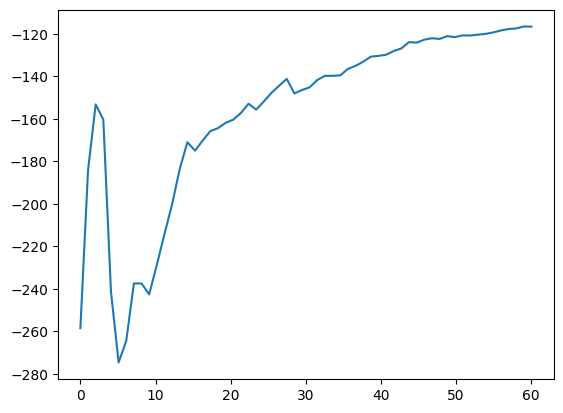

In [ ]:
import numpy as np
import keras
from keras.activations import relu, linear
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import gym
import random
from keras.utils import to_categorical

epsilon = 1
gamma = .99
batch_size = 64
memory = deque(maxlen=1000000)
memory2 = deque(maxlen=1000000)
min_eps = 0.01

learning_rate = 0.001
def update_prior(mini_batch_index,who):

  if who >= 50:

    states = []
    actions = []
    next_states = []
    rewards = []
    finishes = []
    for index in mini_batch_index:
          states.append(memory[index][0])
          actions.append(memory[index][1])
          next_states.append(memory[index][2])
          rewards.append(memory[index][3])
          finishes.append(memory[index][4])

    states_ = np.squeeze(states)
    next_states_ = np.squeeze(next_states)


    q_vals_next_state = model1.predict_on_batch(next_states_)
    q_vals_next_state_model_2 = model2.predict_on_batch(next_states_)
    actions_model_2=np.argmax(q_vals_next_state_model_2, axis=1)
    max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_2]
    q_vals_target = model1.predict_on_batch(states_)

    for i in range(64):

      td_errors = np.absolute((rewards[i] + gamma * (max_q_values_next_state[i]) * (1 - finishes[i])) - q_vals_target[i][actions[i]])

      memory[mini_batch_index[i]]= (states[i], actions[i], next_states[i], rewards[i], finishes[i],  td_errors)



  else:
    states = []
    actions = []
    next_states = []
    rewards = []
    finishes = []
    for index in mini_batch_index:
          states.append(memory2[index][0])
          actions.append(memory2[index][1])
          next_states.append(memory2[index][2])
          rewards.append(memory2[index][3])
          finishes.append(memory2[index][4])


    states_ = np.squeeze(states)
    next_states_ = np.squeeze(next_states)


    q_vals_next_state = model2.predict_on_batch(next_states_)
    q_vals_next_state_model_1 = model1.predict_on_batch(next_states_)
    actions_model_1=np.argmax(q_vals_next_state_model_1, axis=1)
    max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_1]
    q_vals_target = model1.predict_on_batch(states_)


    for i in range(64):

      td_errors = np.absolute((rewards[i] + gamma * (max_q_values_next_state[i]) * (1 - finishes[i])) - q_vals_target[i][actions[i]])

      memory2[mini_batch_index[i]]= (states[i], actions[i], next_states[i], rewards[i], finishes[i],  td_errors)




model1 = keras.Sequential()
model1.add(keras.layers.Dense(64, input_dim=8, activation=relu))
model1.add(keras.layers.Dense(64, activation=relu))
model1.add(keras.layers.Dense(4, activation=linear))
opt =keras.optimizers.Adam(learning_rate=learning_rate )
model1.compile(loss="mse", optimizer=opt)

model2 = keras.Sequential()
model2.add(keras.layers.Dense(64, input_dim=8, activation=relu))
model2.add(keras.layers.Dense(64, activation=relu))
model2.add(keras.layers.Dense(4, activation=linear))
opt2 =keras.optimizers.Adam(learning_rate=learning_rate )
model2.compile(loss="mse", optimizer=opt2)



class GradientWeightedUpdateCallback(tf.keras.callbacks.Callback):
    def __init__(self, weights,model,inputs,targets):
        super(GradientWeightedUpdateCallback, self).__init__()
        self.weights = weights
        self.model = model
        self.inputs = inputs
        self.targets= targets


    def on_train_batch_end(self, batch, logs=None):
        # Get the gradients
        with tf.GradientTape() as tape:
            predictions = self.model(self.inputs)  # Replace 'inputs' with your input data

            loss_value = self.model.compiled_loss(tf.convert_to_tensor(self.targets), predictions)  # Replace 'targets' with your target labels
        gradients = tape.gradient(loss_value, self.model.trainable_weights)




        # Perform element-wise multiplication of gradients and weights
        weighted_gradients = [g*w  for g, w in zip(gradients, self.weights)]

        # Apply the weighted gradients to update the model parameters
        self.model.optimizer.apply_gradients(zip(weighted_gradients, self.model.trainable_weights))
        return


def replay_experiences(who):
    global epsilon
    if len(memory) >= batch_size and len(memory2) >= batch_size  :
        if who >= 50:
          priorities = np.array([ (exp[5])**0.2  for exp in memory])

          priorities =priorities/ np.sum(priorities)


          mini_batch_index = np.random.choice(len(memory), batch_size, p= priorities,replace= True)
        else:

          priorities = np.array([ (exp[5])**0.2  for exp in memory2])

          priorities =priorities/ np.sum(priorities)


          mini_batch_index = np.random.choice(len(memory2), batch_size, p= priorities,replace= True)


        #batch = random.sample(memory, batch_size)
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        for index in mini_batch_index:
          if who >= 50:
            states.append(memory[index][0])

            actions.append(memory[index][1])
            next_states.append(memory[index][2])
            rewards.append(memory[index][3])
            finishes.append(memory[index][4])
          else:
            states.append(memory2[index][0])
            actions.append(memory2[index][1])
            next_states.append(memory2[index][2])
            rewards.append(memory2[index][3])
            finishes.append(memory2[index][4])

        actions = np.array(actions)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)




        if who >= 50:

          q_vals_next_state = model1.predict_on_batch(next_states)
          q_vals_next_state_model_2 = model2.predict_on_batch(next_states)
          actions_model_2=np.argmax(q_vals_next_state_model_2, axis=1)
          max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_2]
          q_vals_target = model1.predict_on_batch(states)

          we = [((1/w)* (1/len(memory)))**0.8   for  w in  priorities[mini_batch_index]]

          max_w = np.amax(we)

          curr= list( element[actions[idx]] for idx,element in enumerate(q_vals_target))
          td = np.abs((rewards + gamma*max_q_values_next_state )- curr)
          we = [er*(w)  for er, w in zip(td, we)]


          we = [w/max_w  for  w in we]


          q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)

          callback = GradientWeightedUpdateCallback(we,model1,states, q_vals_target)
          model1.fit(states, q_vals_target, verbose=0,callbacks=[callback])
          update_prior(mini_batch_index,who)

          if epsilon > min_eps:
              epsilon *= 0.996

        else:

          q_vals_next_state = model2.predict_on_batch(next_states)
          q_vals_next_state_model_1 = model1.predict_on_batch(next_states)
          actions_model_1=np.argmax(q_vals_next_state_model_1, axis=1)
          max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_1]
          q_vals_target = model2.predict_on_batch(states)

          we = [((1/w)* (1/len(memory)))**0.8  for  w in  priorities[mini_batch_index]]

          max_w = np.amax(we)

          curr= list( element[actions[idx]] for idx,element in enumerate(q_vals_target))
          td = np.abs((rewards + gamma*max_q_values_next_state )- curr)
          we = [er*(w)  for er, w in zip(td, we)]


          we = [w/max_w  for  w in we]


          q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)

          callback = GradientWeightedUpdateCallback(we,model2,states, q_vals_target)
          model2.fit(states, q_vals_target, verbose=0,callbacks=[callback])
          update_prior(mini_batch_index,who)

          if epsilon > min_eps:
              epsilon *= 0.996





def priotirized_append(who , state, action, next_state, reward, finished):
    if who >=50:




      q_vals_next_state = model1.predict_on_batch(next_state)
      q_vals_next_state_model_2 = model2.predict_on_batch(next_state)
      actions_model_2=np.argmax(q_vals_next_state_model_2)
      max_q_values_next_state =  q_vals_next_state[0][actions_model_2]
      q_vals_target = model1.predict_on_batch(state)

      td_errors = np.abs((reward + gamma * (max_q_values_next_state) * (1 - finished) ) - q_vals_target[0][actions_model_2])

      memory.append((state, action, next_state, reward, finished,  td_errors))




    else:


      q_vals_next_state = model2.predict_on_batch(next_state)
      q_vals_next_state_model_1 = model1.predict_on_batch(next_state)
      actions_model_1=np.argmax(q_vals_next_state_model_1)

      max_q_values_next_state =  q_vals_next_state[0][actions_model_1]
      q_vals_target = model2.predict_on_batch(state)

      td_errors = np.abs((reward + gamma * (max_q_values_next_state) * (1 - finished) ) - q_vals_target[0][actions_model_1])

      memory2.append((state, action, next_state, reward, finished,  td_errors))





def aaa():
    env = gym.make("LunarLander-v2")
    env.seed(1)
    num_episodes = 400
    np.random.seed(1)
    scores  = []
    avg_scores=[]
    num_iters= 0
    for i in range(60):
        score = 0
        num_iters+=1
        state = env.reset()
        finished = False

        for j in range(3000):
            state = np.reshape(state, (1, 8))
            who =np.random.choice(100)
            if np.random.random() <= epsilon:
                action =  np.random.choice(4)
            else:
              if who >= 50:
                action_values = model1.predict(state)
                action = np.argmax(action_values[0])
              else:
                action_values = model2.predict(state)
                action = np.argmax(action_values[0])

            next_state, reward, finished, metadata  = env.step(action)
            next_state = np.reshape(next_state, (1, 8))

            priotirized_append(who,state, action, next_state, reward, finished)

            replay_experiences(who)
            score += reward
            state = next_state
            if finished:
                scores.append(score)

                avg_scores.append(np.mean(scores[-100:]))

                print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
                break
    return avg_scores, num_iters
avg_scores_prio_dueling_double_dqn, num_iters_prio_dueling_double_dqn =aaa()
y = np.array(avg_scores_prio_dueling_double_dqn)
x = np.linspace(0, num_iters_prio_dueling_double_dqn, y.shape[0])

plt.plot(x, y, label='Priotrized Dueling Double DQN reward')

# Priotrized Dueling Double DQN

In [ ]:
import numpy as np
import keras
from keras.activations import relu, linear
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import gym
import random
from keras.utils import to_categorical

epsilon = 1
gamma = .99
batch_size = 64
memory = deque(maxlen=1000000)
memory2 = deque(maxlen=1000000)
min_eps = 0.01

learning_rate = 0.001
def update_prior(mini_batch_index,who):

  if who >= 50:

    states = []
    actions = []
    next_states = []
    rewards = []
    finishes = []
    for index in mini_batch_index:
          states.append(memory[index][0])
          actions.append(memory[index][1])
          next_states.append(memory[index][2])
          rewards.append(memory[index][3])
          finishes.append(memory[index][4])

    states_ = np.squeeze(states)
    next_states_ = np.squeeze(next_states)


    q_vals_next_state = model1.predict_on_batch(next_states_)
    q_vals_next_state_model_2 = model2.predict_on_batch(next_states_)
    actions_model_2=np.argmax(q_vals_next_state_model_2, axis=1)
    max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_2]
    q_vals_target = model1.predict_on_batch(states_)

    for i in range(64):

      td_errors = np.absolute((rewards[i] + gamma * (max_q_values_next_state[i]) * (1 - finishes[i])) - q_vals_target[i][actions[i]])

      memory[mini_batch_index[i]]= (states[i], actions[i], next_states[i], rewards[i], finishes[i],  td_errors)



  else:
    states = []
    actions = []
    next_states = []
    rewards = []
    finishes = []
    for index in mini_batch_index:
          states.append(memory2[index][0])
          actions.append(memory2[index][1])
          next_states.append(memory2[index][2])
          rewards.append(memory2[index][3])
          finishes.append(memory2[index][4])


    states_ = np.squeeze(states)
    next_states_ = np.squeeze(next_states)


    q_vals_next_state = model2.predict_on_batch(next_states_)
    q_vals_next_state_model_1 = model1.predict_on_batch(next_states_)
    actions_model_1=np.argmax(q_vals_next_state_model_1, axis=1)
    max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_1]
    q_vals_target = model1.predict_on_batch(states_)


    for i in range(64):

      td_errors = np.absolute((rewards[i] + gamma * (max_q_values_next_state[i]) * (1 - finishes[i])) - q_vals_target[i][actions[i]])

      memory2[mini_batch_index[i]]= (states[i], actions[i], next_states[i], rewards[i], finishes[i],  td_errors)


def DDQN_model():
    input_layer = keras.layers.Input(shape=8)
    dense1 = keras.layers.Dense(64, activation=relu)(input_layer)
    dense2 = keras.layers.Dense(64, activation=relu)(dense1)

    state_value = keras.layers.Dense(1, activation=linear)(dense2)

    action_advantage = keras.layers.Dense(4, activation=linear)(dense2)

    output_layer =  (state_value + (action_advantage - tf.math.reduce_mean(action_advantage, axis=1, keepdims=True)))


    model1 = keras.Model(inputs=input_layer, outputs=output_layer)
    return model1


def DDQN_model2():
    input_layer = keras.layers.Input(shape=8)
    dense1 = keras.layers.Dense(64, activation=relu)(input_layer)
    dense2 = keras.layers.Dense(64, activation=relu)(dense1)

    state_value = keras.layers.Dense(1, activation=linear)(dense2)

    action_advantage = keras.layers.Dense(4, activation=linear)(dense2)

    output_layer =  (state_value + (action_advantage - tf.math.reduce_mean(action_advantage, axis=1, keepdims=True)))


    model2 = keras.Model(inputs=input_layer, outputs=output_layer)
    return model2


model1 = DDQN_model()

opt =keras.optimizers.Adam(learning_rate=learning_rate )
model1.compile(loss="mse", optimizer=opt)

model2 =  DDQN_model2()
opt2 =keras.optimizers.Adam(learning_rate=learning_rate )
model2.compile(loss="mse", optimizer=opt2)



class GradientWeightedUpdateCallback(tf.keras.callbacks.Callback):
    def __init__(self, weights,model,inputs,targets):
        super(GradientWeightedUpdateCallback, self).__init__()
        self.weights = weights
        self.model = model
        self.inputs = inputs
        self.targets= targets


    def on_train_batch_end(self, batch, logs=None):
        # Get the gradients
        with tf.GradientTape() as tape:
            predictions = self.model(self.inputs)  # Replace 'inputs' with your input data

            loss_value = self.model.compiled_loss(tf.convert_to_tensor(self.targets), predictions)  # Replace 'targets' with your target labels
        gradients = tape.gradient(loss_value, self.model.trainable_weights)




        # Perform element-wise multiplication of gradients and weights
        weighted_gradients = [g*w  for g, w in zip(gradients, self.weights)]

        # Apply the weighted gradients to update the model parameters
        self.model.optimizer.apply_gradients(zip(weighted_gradients, self.model.trainable_weights))
        return


def replay_experiences(who):
    global epsilon
    if len(memory) >= batch_size and len(memory2) >= batch_size  :
        if who >= 50:
          priorities = np.array([ (exp[5])**0.2  for exp in memory])

          priorities =priorities/ np.sum(priorities)


          mini_batch_index = np.random.choice(len(memory), batch_size, p= priorities,replace= True)
        else:

          priorities = np.array([ (exp[5])**0.2  for exp in memory2])

          priorities =priorities/ np.sum(priorities)


          mini_batch_index = np.random.choice(len(memory2), batch_size, p= priorities,replace= True)


        #batch = random.sample(memory, batch_size)
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        for index in mini_batch_index:
          if who >= 50:
            states.append(memory[index][0])

            actions.append(memory[index][1])
            next_states.append(memory[index][2])
            rewards.append(memory[index][3])
            finishes.append(memory[index][4])
          else:
            states.append(memory2[index][0])
            actions.append(memory2[index][1])
            next_states.append(memory2[index][2])
            rewards.append(memory2[index][3])
            finishes.append(memory2[index][4])

        actions = np.array(actions)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)




        if who >= 50:

          q_vals_next_state = model1.predict_on_batch(next_states)
          q_vals_next_state_model_2 = model2.predict_on_batch(next_states)
          actions_model_2=np.argmax(q_vals_next_state_model_2, axis=1)
          max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_2]
          q_vals_target = model1.predict_on_batch(states)

          we = [((1/w)* (1/len(memory)))**0.8   for  w in  priorities[mini_batch_index]]

          max_w = np.amax(we)

          curr= list( element[actions[idx]] for idx,element in enumerate(q_vals_target))
          td = np.abs((rewards + gamma*max_q_values_next_state )- curr)
          we = [er*(w)  for er, w in zip(td, we)]


          we = [w/max_w  for  w in we]


          q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)

          callback = GradientWeightedUpdateCallback(we,model1,states, q_vals_target)
          model1.fit(states, q_vals_target, verbose=0,callbacks=[callback])
          update_prior(mini_batch_index,who)

          if epsilon > min_eps:
              epsilon *= 0.996

        else:

          q_vals_next_state = model2.predict_on_batch(next_states)
          q_vals_next_state_model_1 = model1.predict_on_batch(next_states)
          actions_model_1=np.argmax(q_vals_next_state_model_1, axis=1)
          max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_1]
          q_vals_target = model2.predict_on_batch(states)

          we = [((1/w)* (1/len(memory)))**0.8  for  w in  priorities[mini_batch_index]]

          max_w = np.amax(we)

          curr= list( element[actions[idx]] for idx,element in enumerate(q_vals_target))
          td = np.abs((rewards + gamma*max_q_values_next_state )- curr)
          we = [er*(w)  for er, w in zip(td, we)]


          we = [w/max_w  for  w in we]


          q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)

          callback = GradientWeightedUpdateCallback(we,model2,states, q_vals_target)
          model2.fit(states, q_vals_target, verbose=0,callbacks=[callback])
          update_prior(mini_batch_index,who)

          if epsilon > min_eps:
              epsilon *= 0.996





def priotirized_append(who , state, action, next_state, reward, finished):
    if who >=50:




      q_vals_next_state = model1.predict_on_batch(next_state)
      q_vals_next_state_model_2 = model2.predict_on_batch(next_state)
      actions_model_2=np.argmax(q_vals_next_state_model_2)
      max_q_values_next_state =  q_vals_next_state[0][actions_model_2]
      q_vals_target = model1.predict_on_batch(state)

      td_errors = np.abs((reward + gamma * (max_q_values_next_state) * (1 - finished) ) - q_vals_target[0][actions_model_2])

      memory.append((state, action, next_state, reward, finished,  td_errors))




    else:


      q_vals_next_state = model2.predict_on_batch(next_state)
      q_vals_next_state_model_1 = model1.predict_on_batch(next_state)
      actions_model_1=np.argmax(q_vals_next_state_model_1)

      max_q_values_next_state =  q_vals_next_state[0][actions_model_1]
      q_vals_target = model2.predict_on_batch(state)

      td_errors = np.abs((reward + gamma * (max_q_values_next_state) * (1 - finished) ) - q_vals_target[0][actions_model_1])

      memory2.append((state, action, next_state, reward, finished,  td_errors))





def aaa():
    env = gym.make("LunarLander-v2")
    env.seed(1)
    num_episodes = 400
    np.random.seed(1)
    scores  = []
    avg_scores=[]
    num_iters= 0
    for i in range(60):
        score = 0
        num_iters+=1
        state = env.reset()
        finished = False

        for j in range(3000):
            state = np.reshape(state, (1, 8))
            who =np.random.choice(100)
            if np.random.random() <= epsilon:
                action =  np.random.choice(4)
            else:
              if who >= 50:
                action_values = model1.predict(state)
                action = np.argmax(action_values[0])
              else:
                action_values = model2.predict(state)
                action = np.argmax(action_values[0])

            next_state, reward, finished, metadata  = env.step(action)
            next_state = np.reshape(next_state, (1, 8))

            priotirized_append(who,state, action, next_state, reward, finished)

            replay_experiences(who)
            score += reward
            state = next_state
            if finished:
                scores.append(score)

                avg_scores.append(np.mean(scores[-100:]))

                print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
                break
    return avg_scores, num_iters
avg_scores_prio_dueling_double_dqn, num_iters_prio_dueling_double_dqn =aaa()
y = np.array(avg_scores_prio_dueling_double_dqn)
x = np.linspace(0, num_iters_prio_dueling_double_dqn, y.shape[0])

plt.plot(x, y, label='Priotrized Dueling Double DQN reward')


Episode = 0, Score = -129.57267446732538, Avg_Score = -129.57267446732538
1/1 [==============================] - 0s 21ms/step
Episode = 1, Score = -93.64354511692488, Avg_Score = -111.60810979212513
1/1 [==============================] - 0s 21ms/step
Episode = 2, Score = -210.45032831155845, Avg_Score = -144.55551596526956
1/1 [==============================] - 0s 26ms/step
Episode = 3, Score = -269.34006623359807, Avg_Score = -175.7516535323517
1/1 [==============================] - 0s 20ms/step
Episode = 4, Score = -77.4550502505332, Avg_Score = -156.092332875988
1/1 [==============================] - 0s 21ms/step
Episode = 5, Score = -444.4579815741256, Avg_Score = -204.1532743256776
1/1 [==============================] - 0s 19ms/step
Episode = 6, Score = -101.24054250520199, Avg_Score = -189.4514554941811
1/1 [==============================] - 0s 21ms/step
Episode = 7, Score = -276.6724195491356, Avg_Score = -200.35407600105037
1/1 [==============================] - 0s 20ms/step
Ep

KeyboardInterrupt: ignored

# Dueling DDQN


Episode = 0, Score = -123.23748342437582, Avg_Score = -123.23748342437582
Episode = 1, Score = -172.7811278691882, Avg_Score = -148.00930564678202


<ipython-input-28-65979b4e9507>:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_choices = np.array(memory2)
<ipython-input-28-65979b4e9507>:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_choices = np.array(memory)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 20ms/step
Episode = 54, Score = -117.96392246453847, Avg_Score = -109.54587175101793
1/1 [==============================] - 0s 20ms/step
Episode = 55, Score = -110.59536024231737, Avg_Score = -109.564612616934
1/1 [==============================] - 0s 18ms/step
Episode = 56, Score = -107.59354960594335, Avg_Score = -109.5300325641096
1/1 [==============================] - 0s 21ms/step
Episode = 57, Score = -102.72605257217667, Avg_Score = -109.4127225642487
1/1 [==============================] - 0s 18ms/step
Episode = 58, Score = -50.39452508623326, Avg_Score = -108.41241413241792
1/1 [==============================] - 0s 18ms/step
Episode = 59, Score = -72.89771066934351, Avg_Score = -107.82050240803336


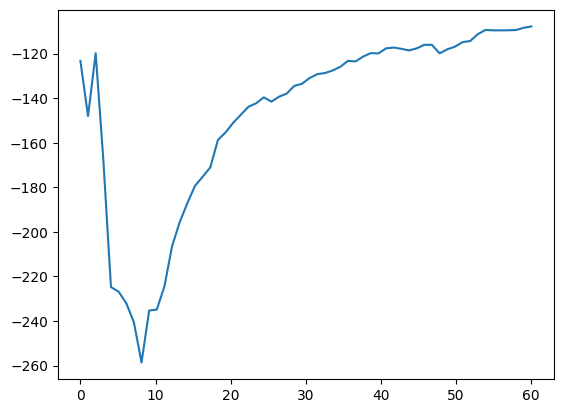

In [ ]:
import numpy as np
import keras
from keras.activations import relu, linear

import matplotlib.pyplot as plt
from collections import deque
import gym
import random
from keras.utils import to_categorical


learning_rate = 0.001
def DDQN_model1():
    input_layer = keras.layers.Input(shape=8)
    dense1 = keras.layers.Dense(64, activation=relu)(input_layer)
    dense2 = keras.layers.Dense(64, activation=relu)(dense1)

    state_value = keras.layers.Dense(1, activation=linear)(dense2)


    action_advantage = keras.layers.Dense(4, activation=linear)(dense2)


    output_layer =  (state_value + (action_advantage - tf.math.reduce_mean(action_advantage, axis=1, keepdims=True)))


    model1 = keras.Model(inputs=input_layer, outputs=output_layer)
    return model1


def DDQN_model2():
    input_layer = keras.layers.Input(shape=8)
    dense1 = keras.layers.Dense(64, activation=relu)(input_layer)
    dense2 = keras.layers.Dense(64, activation=relu)(dense1)

    state_value = keras.layers.Dense(1, activation=linear)(dense2)


    action_advantage = keras.layers.Dense(4, activation=linear)(dense2)


    output_layer =  (state_value + (action_advantage - tf.math.reduce_mean(action_advantage, axis=1, keepdims=True)))


    model2 = keras.Model(inputs=input_layer, outputs=output_layer)
    return model2

model1 = DDQN_model1()
opt =keras.optimizers.Adam(learning_rate=learning_rate )
model1.compile(loss="mse", optimizer=opt)

model2 = DDQN_model2()
opt2 =keras.optimizers.Adam(learning_rate=learning_rate )
model2.compile(loss="mse", optimizer=opt2)


epsilon = 1
gamma = .99
batch_size = 64
memory = deque(maxlen=1000000)
memory2 = deque(maxlen=1000000)
min_eps = 0.01


def replay_experiences(who):
    global epsilon
    if len(memory) >= batch_size and len(memory2) >= batch_size:
        if who >= 50:
          sample_choices = np.array(memory)
          mini_batch_index = np.random.choice(len(sample_choices), batch_size,replace= True)
        else:
          sample_choices = np.array(memory2)
          mini_batch_index = np.random.choice(len(sample_choices), batch_size,replace= True)

        #batch = random.sample(memory, batch_size)
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        for index in mini_batch_index:
          if who >= 50:
            states.append(memory[index][0])
            actions.append(memory[index][1])
            next_states.append(memory[index][2])
            rewards.append(memory[index][3])
            finishes.append(memory[index][4])
          else:
            states.append(memory2[index][0])
            actions.append(memory2[index][1])
            next_states.append(memory2[index][2])
            rewards.append(memory2[index][3])
            finishes.append(memory2[index][4])
        states = np.array(states)
        actions = np.array(actions)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)


        if who >= 50:
          q_vals_next_state = model2.predict_on_batch(next_states)
          q_vals_next_state_model_1 = model1.predict_on_batch(next_states)
          actions_model_1=np.argmax(q_vals_next_state_model_1, axis=1)
          max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_1]

          q_vals_target = model1.predict_on_batch(states)
          q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)
          model1.fit(states, q_vals_target, verbose=0)

          if epsilon > min_eps:
              epsilon *= 0.996

        else:
          q_vals_next_state = model1.predict_on_batch(next_states)
          q_vals_next_state_model_2 = model2.predict_on_batch(next_states)
          actions_model_2=np.argmax(q_vals_next_state_model_2, axis=1)
          max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_2]

          q_vals_target = model2.predict_on_batch(states)
          q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)
          model2.fit(states, q_vals_target, verbose=0)

          if epsilon > min_eps:
              epsilon *= 0.996



def aaa():
    env = gym.make("LunarLander-v2" )
    env.seed(1)
    num_episodes = 400
    np.random.seed(1)
    scores  = []
    avg_scores=[]
    num_iters= 0
    for i in range(60):
        score = 0
        num_iters+=1
        state = env.reset()
        finished = False

        for j in range(3000):
            state = np.reshape(state, (1, 8))
            who =np.random.choice(100)
            if np.random.random() <= epsilon:
                action =  np.random.choice(4)
            else:
              if who >= 50:
                action_values = model1.predict(state)
                action = np.argmax(action_values[0])
              else:
                action_values = model2.predict(state)
                action = np.argmax(action_values[0])

            next_state, reward, finished, metadata  = env.step(action)
            next_state = np.reshape(next_state, (1, 8))
            if who >= 50 :
              memory.append((state, action, next_state, reward, finished))
            else:
              memory2.append((state, action, next_state, reward, finished))

            replay_experiences(who)
            score += reward
            state = next_state
            if finished:
                scores.append(score)

                avg_scores.append(np.mean(scores[-100:]))

                print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
                break
    return avg_scores, num_iters
avg_scores_dueling_double_dqn, num_iters_dueling_double_dqn =aaa()
y = np.array(avg_scores_dueling_double_dqn)
x = np.linspace(0, num_iters_dueling_double_dqn, y.shape[0])

plt.plot(x, y, label='Dueling DDQN reward')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
<ipython-input-1-9b0650d99b8b>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

Episode = 0, Score = -258.5040237311447, Avg_Score = -258.5040237311447


<ipython-input-1-9b0650d99b8b>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_choices = np.array(memory)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 22ms/step
Episode = 15, Score = -29.953711794623203, Avg_Score = -119.13065129372588
1/1 [==============================] - 0s 21ms/step
Episode = 16, Score = -237.52227615954482, Avg_Score = -126.094864521127
1/1 [==============================] - 0s 17ms/step
Episode = 17, Score = -7.825591441558004, Avg_Score = -119.52434935003983
1/1 [==============================] - 0s 17ms/step
Episode = 18, Score = 17.608021310665606, Avg_Score = -112.30685615737112
1/1 [==============================] - 0s 17ms/step
Episode = 19, Score = 63.3749352634983, Avg_Score = -103.52276658632766
1/1 [==============================] - 0s 19ms/step
Episode = 20, Score = -529.9076962069464, Avg_Score = -123.82681085397616
1/1 [==============================] - 0s 17ms/step
Episode = 21, Score = -571.7802790651829, Avg_Score = -144.18833213630376
1/1 [==============================] - 0s 19ms/step
Episode = 22, Score =

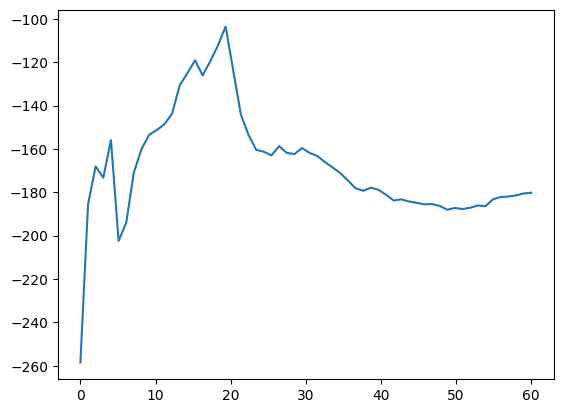

In [ ]:
import numpy as np
import keras
from keras.activations import relu, linear

import matplotlib.pyplot as plt
from collections import deque
import gym
import random
from keras.utils import to_categorical


learning_rate = 0.001



model1 = keras.Sequential()
model1.add(keras.layers.Dense(64, input_dim=8, activation=relu))
model1.add(keras.layers.Dense(64, activation=relu))
model1.add(keras.layers.Dense(4, activation=linear))
opt =keras.optimizers.Adam(learning_rate=learning_rate )
model1.compile(loss="mse", optimizer=opt)

model2 = keras.Sequential()
model2.add(keras.layers.Dense(64, input_dim=8, activation=relu))
model2.add(keras.layers.Dense(64, activation=relu))
model2.add(keras.layers.Dense(4, activation=linear))
opt2 =keras.optimizers.Adam(learning_rate=learning_rate )
model2.compile(loss="mse", optimizer=opt2)


epsilon = 1
gamma = .99
batch_size = 64
memory = deque(maxlen=1000000)
memory2 = deque(maxlen=1000000)
min_eps = 0.01


def replay_experiences(who):
    global epsilon
    if len(memory) >= batch_size and len(memory2) >= batch_size:
        if who >= 50:
          sample_choices = np.array(memory)
          mini_batch_index = np.random.choice(len(sample_choices), batch_size,replace= True)
        else:
          sample_choices = np.array(memory2)
          mini_batch_index = np.random.choice(len(sample_choices), batch_size,replace= True)

        #batch = random.sample(memory, batch_size)
        states = []
        actions = []
        next_states = []
        rewards = []
        finishes = []
        for index in mini_batch_index:
          if who >= 50:
            states.append(memory[index][0])
            actions.append(memory[index][1])
            next_states.append(memory[index][2])
            rewards.append(memory[index][3])
            finishes.append(memory[index][4])
          else:
            states.append(memory2[index][0])
            actions.append(memory2[index][1])
            next_states.append(memory2[index][2])
            rewards.append(memory2[index][3])
            finishes.append(memory2[index][4])
        states = np.array(states)
        actions = np.array(actions)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        finishes = np.array(finishes)
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)


        if who >= 50:
          q_vals_next_state = model2.predict_on_batch(next_states)
          q_vals_next_state_model_1 = model1.predict_on_batch(next_states)
          actions_model_1=np.argmax(q_vals_next_state_model_1, axis=1)
          max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_1]

          q_vals_target = model1.predict_on_batch(states)
          q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)
          model1.fit(states, q_vals_target, verbose=0)

          if epsilon > min_eps:
              epsilon *= 0.996

        else:
          q_vals_next_state = model1.predict_on_batch(next_states)
          q_vals_next_state_model_2 = model2.predict_on_batch(next_states)
          actions_model_2=np.argmax(q_vals_next_state_model_2, axis=1)
          max_q_values_next_state =  q_vals_next_state[np.arange(batch_size),actions_model_2]

          q_vals_target = model2.predict_on_batch(states)
          q_vals_target[np.arange(batch_size), actions] = rewards + gamma * (max_q_values_next_state) * (1 - finishes)
          model2.fit(states, q_vals_target, verbose=0)

          if epsilon > min_eps:
              epsilon *= 0.996



def aaa():
    env = gym.make("LunarLander-v2" )
    env.seed(1)
    num_episodes = 400
    np.random.seed(1)
    scores  = []
    avg_scores=[]
    num_iters= 0
    for i in range(60):
        score = 0
        num_iters+=1
        state = env.reset()
        finished = False

        for j in range(3000):
            state = np.reshape(state, (1, 8))
            who =np.random.choice(100)
            if np.random.random() <= epsilon:
                action =  np.random.choice(4)
            else:
              if who >= 50:
                action_values = model1.predict(state)
                action = np.argmax(action_values[0])
              else:
                action_values = model2.predict(state)
                action = np.argmax(action_values[0])

            next_state, reward, finished, metadata  = env.step(action)
            next_state = np.reshape(next_state, (1, 8))
            if who >= 50 :
              memory.append((state, action, next_state, reward, finished))
            else:
              memory2.append((state, action, next_state, reward, finished))

            replay_experiences(who)
            score += reward
            state = next_state
            if finished:
                scores.append(score)

                avg_scores.append(np.mean(scores[-100:]))

                print("Episode = {}, Score = {}, Avg_Score = {}".format(i, score, np.mean(scores[-100:])))
                break
    return avg_scores, num_iters
avg_scores_dueling_double_dqn, num_iters_dueling_double_dqn =aaa()
y = np.array(avg_scores_dueling_double_dqn)
x = np.linspace(0, num_iters_dueling_double_dqn, y.shape[0])

plt.plot(x, y, label='Dueling DDQN reward')